In [4]:
!pip3 install pytorch_transformers

## Загружаем датасет из задания 1

In [5]:
from google.colab import drive

drive.mount('/content/drive')

#!cp drive/'My Drive'/'Colab Notebooks'/BERT/'Bert News'/news_3k.csv ./news_3k.csv
!cp drive/'My Drive'/'Colab Notebooks'/BERT/'Bert News'/news_15k.csv ./news_15k.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd

#data = pd.read_csv('news_3k.csv', sep=';')
data = pd.read_csv('news_15k.csv', sep=';')
data['tags'] = data['tags'].apply(lambda l: eval(l) if '[' in l else l)
data.head()

,title,content,url,tags,source
0,Прятавший мальчика в подвале мужчина несколько...,Более 50 дней удерживавший семилетнего Савели...,http://www.vesti.ru/article/2488087,"[происшествия, новости, ребенок, похищение, Вл...",VestiNewsParser
1,В подмосковном лесу нашли связанный труп с пак...,В минувший понедельник неподалеку от деревни ...,http://www.vesti.ru/article/2488068,"[происшествия, убийство, новости, Клин, Москов...",VestiNewsParser
2,ФИФА вручит приз The Best лучшим футболистам с...,В отличие от французского еженедельника Franc...,http://www.vesti.ru/article/2488047,"[спорт, новости, футбол, Золотой мяч, ФИФА/FIFA]",VestiNewsParser
3,Главред RT аплодирует новому закону об информа...,"Изменений в федеральный закон ""Об информации ...",http://www.vesti.ru/article/2488029,"[политика, новости, безопасность, закон, Росси...",VestiNewsParser
4,Ученые нашли в водах Крыма неизвестные науке в...,В Крыму учёные описали неизвестные науке виды...,http://www.vesti.ru/article/2488031,"[общество, ученые, открытие/изобретение, новос...",VestiNewsParser


## Собираем самые частые теги и составляем из них набор классов

In [7]:
from collections import Counter

vesti_count = Counter()
for tags in data[data.source == 'VestiNewsParser'].tags:
    vesti_count += Counter([t.lower() for t in tags])

set_vesti = set(vesti_count)

lenta_count = Counter()
for tags in data[data.source == 'LentaNewsParser'].tags:
    lenta_count += Counter([tags.lower()])

set_lenta = set(lenta_count)

classes = lenta_count + vesti_count

In [8]:
for key in classes.copy():
  if classes[key] < 100:
    del classes[key]

classes = set(classes)

In [9]:
def check_class(row):
    if row['source'] == 'VestiNewsParser':
        for tag in row['tags']:
          tag = tag.lower()
          if tag in classes:
            return tag
    elif row['source'] == 'LentaNewsParser':
        tag = row['tags'].lower()
        if tag in classes:
          return tag
    else:
      for cls in classes:
        if cls in row['content']:
          return cls

data['main_tag'] = data.apply(check_class, axis=1)
data['main_tag'].value_counts()

общество           2941
политика           1330
чита                925
происшествия        851
закон               772
спорт               699
журналист           540
культура            483
вор                 467
россия              466
экономика           391
исследования        387
самолет             386
орган               386
ученые              363
закавказье          267
наука               192
следствие и суд     151
тв и радио          139
кино                122
госэкономика        119
бокс и мма          112
квартира            112
футбол              111
музыка              101
белоруссия          100
люди                100
новости              66
регионы              45
криминал             38
космос               31
москва               23
концерт              21
Name: main_tag, dtype: int64

In [10]:
data = data[~data['main_tag'].isna()]
print(data.shape)
data.head()

(13237, 6)


,title,content,url,tags,source,main_tag
0,Прятавший мальчика в подвале мужчина несколько...,Более 50 дней удерживавший семилетнего Савели...,http://www.vesti.ru/article/2488087,"[происшествия, новости, ребенок, похищение, Вл...",VestiNewsParser,происшествия
1,В подмосковном лесу нашли связанный труп с пак...,В минувший понедельник неподалеку от деревни ...,http://www.vesti.ru/article/2488068,"[происшествия, убийство, новости, Клин, Москов...",VestiNewsParser,происшествия
2,ФИФА вручит приз The Best лучшим футболистам с...,В отличие от французского еженедельника Franc...,http://www.vesti.ru/article/2488047,"[спорт, новости, футбол, Золотой мяч, ФИФА/FIFA]",VestiNewsParser,спорт
3,Главред RT аплодирует новому закону об информа...,"Изменений в федеральный закон ""Об информации ...",http://www.vesti.ru/article/2488029,"[политика, новости, безопасность, закон, Росси...",VestiNewsParser,политика
4,Ученые нашли в водах Крыма неизвестные науке в...,В Крыму учёные описали неизвестные науке виды...,http://www.vesti.ru/article/2488031,"[общество, ученые, открытие/изобретение, новос...",VestiNewsParser,общество


## Дообучаем BERT

In [38]:
import torch

BATCH_SIZE = 64
MAX_LEN = 512

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla T4


In [39]:
class_labels = {}
for index, cls in enumerate(data['main_tag'].unique()):
    class_labels[cls] = index

print(f'Количество классов: {len(class_labels)}')

Количество классов: 33


### Обрезаем строки новости до размера входа

In [40]:
def prepare_strings_to_bert(string, limit=256, string_separator=' '):
  all_words = string.split(string_separator)
  if all_words[0] != '[CLS]':
    all_words = ["[CLS]"] + all_words
  if all_words[-1] != "[SEP]":
    all_words = all_words + ["[SEP]"]

  if len(all_words) >= limit:
    all_words = all_words[:limit//2] + all_words[-limit//2:]
  return string_separator.join(all_words)

In [41]:
import pandas as pd

column_with_data = 'title'
colimn_with_labels = 'main_tag'

dataset = data[[column_with_data, colimn_with_labels]].copy()

dataset[colimn_with_labels] = dataset[colimn_with_labels].apply(lambda x: class_labels[x])
dataset[column_with_data] = dataset[column_with_data].apply(prepare_strings_to_bert)

print(dataset.shape)
dataset.head()

(13237, 2)


,title,main_tag
0,[CLS] Прятавший мальчика в подвале мужчина нес...,0
1,[CLS] В подмосковном лесу нашли связанный труп...,0
2,[CLS] ФИФА вручит приз The Best лучшим футболи...,1
3,[CLS] Главред RT аплодирует новому закону об и...,2
4,[CLS] Ученые нашли в водах Крыма неизвестные н...,3


## Удалим слишком большие и слишком маленькие значения

In [42]:
dataset_v_c = dataset[colimn_with_labels].value_counts()
dataset_v_c

3     2941
2     1330
31     925
0      851
28     772
1      699
27     540
5      483
30     467
18     466
6      391
25     387
29     386
26     386
32     363
10     267
4      192
13     151
19     139
14     122
15     119
12     112
9      112
23     111
17     101
21     100
20     100
7       66
24      45
22      38
16      31
11      23
8       21
Name: main_tag, dtype: int64

In [43]:
dataset_v_c = dataset[colimn_with_labels].value_counts()

classes_to_save = list()
for key, value in dataset_v_c.to_dict().items():
    if 400 < value < 1000:
      classes_to_save.append(key)

dataset = dataset[dataset[colimn_with_labels].isin(classes_to_save)]
dataset.shape

(5203, 2)

### Начинаем обучение

In [44]:
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences


labels = list(dataset[colimn_with_labels])
sentences = list(dataset[column_with_data])

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print('Фрагмент токенизированного текста')
print(tokenized_texts[0][0:50])

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)
print()
print('Фрагмент входного айди')
print(list(input_ids[0]))
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]


train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.2
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.2
)

train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
print()
print('Пример тренировочныхх классов')
print(train_labels)

Фрагмент токенизированного текста
['[CLS]', 'м', '##и', '##н', '##з', '##д', '##р', '##а', '##в', 'п', '##о', '##о', '##б', '##е', '##щ', '##а', '##л', 'у', '##в', '##е', '##л', '##и', '##ч', '##и', '##т', '##ь', 'и', '##м', '##п', '##о', '##р', '##т', 'м', '##е', '##т', '##и', '##л', '##п', '##р', '##е', '##д', '##н', '##и', '##з', '##о', '##л', '##о', '##на', '.', 'э']

Фрагмент входного айди
[101, 1191, 10325, 18947, 29744, 29742, 16856, 10260, 25529, 1194, 14150, 14150, 29740, 15290, 29754, 10260, 29436, 1198, 25529, 15290, 29436, 10325, 29752, 10325, 22919, 23742, 1188, 29745, 29746, 14150, 16856, 22919, 1191, 15290, 22919, 10325, 29436, 29746, 16856, 15290, 29742, 18947, 10325, 29744, 14150, 29436, 14150, 19865, 1012, 1208, 22919, 14150, 1190, 15290, 28598, 16856, 29747, 22919, 25529, 14150, 1010, 1194, 16856, 10325, 29745, 15290, 18947, 17432, 15290, 29745, 14150, 15290, 1194, 16856, 10325, 1195, 15290, 25529, 29745, 10260, 22919, 10325, 29744, 29745, 15290, 1188, 2522, 17258, 1

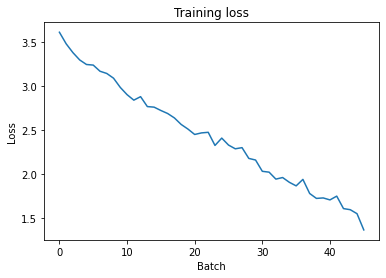

Loss на обучающей выборке: 2.43186


In [45]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from pytorch_transformers import AdamW, BertForSequenceClassification


from IPython.display import clear_output
import matplotlib.pyplot as plt

# Собираем датасет тензоров
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=BATCH_SIZE
)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=BATCH_SIZE
)

# Берем предобученную модель и составляем для нее параметры
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(class_labels))
model.cuda()

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)


# Сохраняем loss для графика
train_loss_set = []
train_loss = 0

# Обучение
model.train()

for step, batch in enumerate(train_dataloader):
    # Распаковываем данные и загружаем на гпу
    b_input_ids, b_input_mask, b_labels = tuple(t.to(device) for t in batch)
    
    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()
    
    # Forward pass
    loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

    train_loss_set.append(loss[0].item())  
    
    # Backward pass
    loss[0].backward()
    
    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss[0].item()
    
    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()

print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

In [46]:
import numpy as np
from sklearn.metrics import accuracy_score

# Валидация
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = label_ids
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 88.07%
